# Imports y primera media




In [23]:
import mne
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import nibabel as nib
from matplotlib.pyplot import figure
from matplotlib import patches

import nilearn
from nilearn.datasets import fetch_spm_auditory
from nilearn import image
from nilearn import masking
import pandas as pd

from os.path import join as opj
from nibabel.testing import data_path
import json
from nipype.interfaces.spm import Level1Design, EstimateModel, EstimateContrast, Normalize12
#tpm_img ='/home/ubuntu/Documents/MATLAB/spm12/tpm/TPM.nii' # normalization template

from nipype.algorithms.modelgen import SpecifySPMModel
from nipype.interfaces.utility import Function, IdentityInterface
from nipype.interfaces.io import SelectFiles, DataSink
from nipype import Workflow, Node
#from bids.layout import BIDSLayout
from nipype.algorithms.misc import Gunzip

import numpy as np
from matplotlib import pyplot as plt
from scipy.io import loadmat
import nibabel as nib



In [24]:
#fMRI


#subject_data = 'C:/Users/vctrf/Documents/Quatrimestre_2/Neuroimagen/proyecto Neuroimagen/sub-xp101/func/sub-xp101_task-eegfmriNF_bold.nii.gz'
subject_data = '/Users/juliagarciacornet/Desktop/Q4/Neuroimatge/project/sub-xp101/func/sub-xp101_task-eegfmriNF_bold.nii.gz'
fmri_img= nib.load(subject_data)


mean_img = image.mean_img(fmri_img)

mean_img
print(mean_img.shape) # passo a 3D

mask = masking.compute_epi_mask(mean_img) #mascara

# Clean and smooth data
#fmri_img = image.clean_img(fmri_img, standardize=False)
#fmri_img = image.smooth_img(fmri_img, 5.)


(106, 106, 32)


In [25]:
from dipy.io.image import load_nifti

fmri_img, affine, img = load_nifti(subject_data , return_img=True)

# Probando con separación Task - Rest 

In [26]:

# fmri_numpy = np.array(fmri_img.dataobj)


fmri_rest=[]
fmri_rest_todos=[]

for rest in range(1,201,20):
    
    fmri_rest=fmri_img[:,:,:,rest:rest+10]
    
    if rest==1:
        fmri_rest_todos=fmri_rest
      

    else:
        fmri_rest_todos= np.concatenate((fmri_rest_todos,fmri_rest), axis=3)
  

print (fmri_rest_todos.shape)


fmri_task=[]
fmri_task_todos=[]

for task in range(11,211,20):
    
    fmri_task=fmri_img[:,:,:,task:task+10]
    
    if task==11:
        fmri_task_todos=fmri_task
    

    else:
        fmri_task_todos= np.concatenate((fmri_task_todos,fmri_task), axis=3)
  

print (fmri_task_todos.shape)



(106, 106, 32, 100)
(106, 106, 32, 100)


In [27]:
import nibabel as nib
from nibabel import Nifti1Image
fmri_rest_todos=nib.Nifti1Image(fmri_rest_todos,affine)  
fmri_task_todos=nib.Nifti1Image(fmri_task_todos,affine)  

mean_img_rest = image.mean_img(fmri_rest_todos)

mean_img_task = image.mean_img(fmri_task_todos)

print (mean_img_rest.shape)
print (mean_img_task.shape)

(106, 106, 32)
(106, 106, 32)


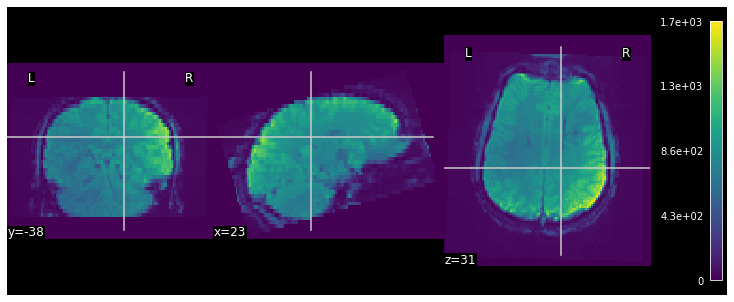

In [28]:
from nilearn import plotting
from matplotlib import pyplot as plt

mask_3D_rest = masking.compute_epi_mask(mean_img_rest)

fig=plt.figure(figsize=(10,4))
plotting.plot_img(mean_img_rest, figure=fig, black_bg=True, colorbar=True, resampling_interpolation='continuous', bg_img=None, vmin=None, vmax=None)



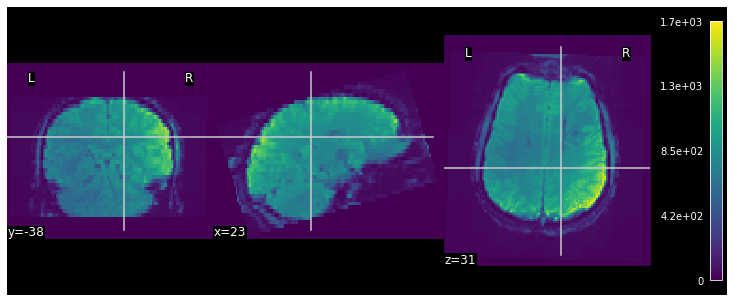

In [29]:
fig=plt.figure(figsize=(10,4))
plotting.plot_img(mean_img_task, figure=fig, black_bg=True, colorbar=True, resampling_interpolation='continuous', bg_img=None, vmin=0, vmax=1700)


[NiftiMapsMasker.fit_transform] loading regions from /Users/juliagarciacornet/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii
Resampling maps


/Users/juliagarciacornet/opt/anaconda3/envs/Neuroimatge/lib/python3.9/site-packages/nilearn/_utils/cache_mixin.py:304: UserWarning: memory_level is currently set to 0 but a Memory object has been provided. Setting memory_level to 1.
  warnings.warn("memory_level is currently set to 0 but "


[Memory]0.1s, 0.0min    : Loading resample_img...
________________________________________resample_img cache loaded - 0.2s, 0.0min
[Memory]1.3s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


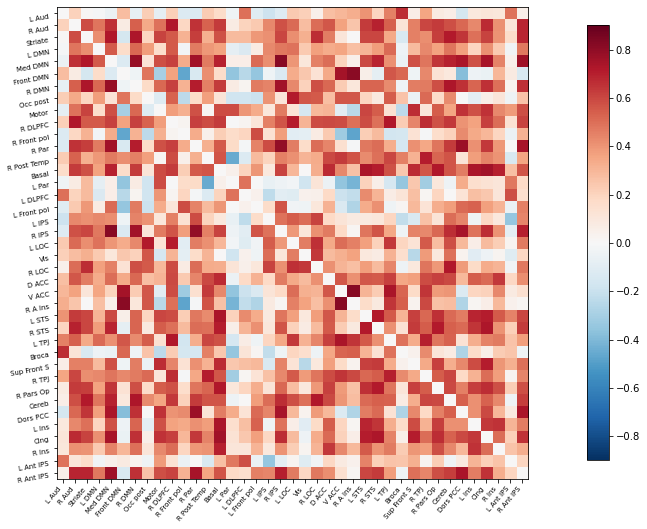

In [39]:
# Resting conectividad

dataset = datasets.fetch_atlas_msdl() # importamos atlas 
atlas_filename = dataset.maps
labels = dataset.labels

# Datos del primer paciente
data = fmri_rest_todos

from nilearn.input_data import NiftiMapsMasker
masker = NiftiMapsMasker(maps_img=atlas_filename, standardize=True,
                         memory='nilearn_cache', verbose=5)

time_series = masker.fit_transform(fmri_rest_todos) #####!!!
                    
from nilearn.connectome import ConnectivityMeasure
correlation_measure = ConnectivityMeasure(kind='correlation')
correlation_matrix = correlation_measure.fit_transform([time_series])[0]

# Display the correlation matrix
import numpy as np
from nilearn import plotting
# Mask out the major diagonal
np.fill_diagonal(correlation_matrix, 0)
fig = plt.figure(figsize=(10,10))
plotting.plot_matrix(correlation_matrix, labels=labels, colorbar=True,
                     vmax=0.9, vmin=-0.9,axes=fig.gca())


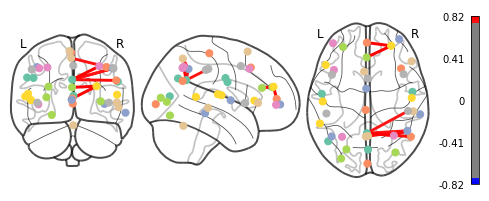

In [40]:
from nilearn import plotting
coords = dataset.region_coords

# We threshold to keep only the 20% of edges with the highest value
# because the graph is very dense
plotting.plot_connectome(correlation_matrix, coords,
                         edge_threshold="99%", colorbar=True)

plotting.show()

[NiftiMapsMasker.fit_transform] loading regions from /Users/juliagarciacornet/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract(<nibabel.nifti1.Nifti1Image object at 0x7fe69984c100>, <nilearn.maskers.nifti_maps_masker._ExtractionFunctor object at 0x7fe6993f2df0>, { 'allow_overlap': True,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'low_pass': None,
  'maps_img': '/Users/juliagarciacornet/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii',
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, sample_mask=None, dtype=None, memory=Memory(location=nilearn_cache/joblib), memory_level=1, verbose=5)
[NiftiMapsMasker.transform_single_i

/Users/juliagarciacornet/opt/anaconda3/envs/Neuroimatge/lib/python3.9/site-packages/nilearn/maskers/nifti_maps_masker.py:502: UserWarning: Persisting input arguments took 1.20s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  region_signals, labels_ = self._cache(


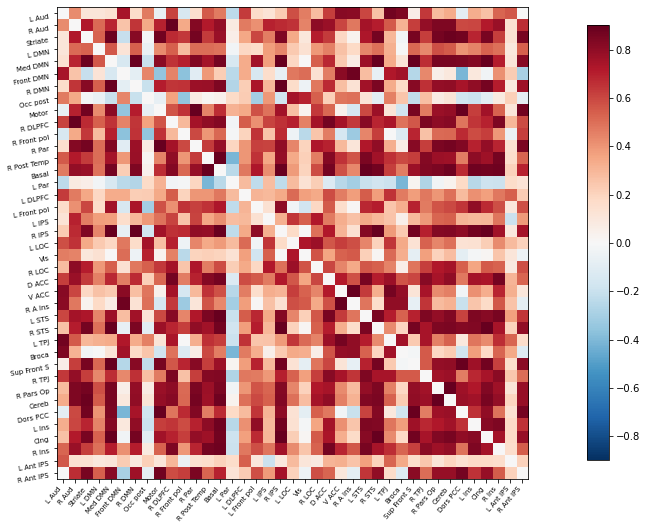

In [41]:
time_series = masker.fit_transform(fmri_task_todos) #####!!!
                    
from nilearn.connectome import ConnectivityMeasure
correlation_measure = ConnectivityMeasure(kind='correlation')
correlation_matrix = correlation_measure.fit_transform([time_series])[0]

# Display the correlation matrix
import numpy as np
from nilearn import plotting
# Mask out the major diagonal
np.fill_diagonal(correlation_matrix, 0)
fig = plt.figure(figsize=(10,10))
plotting.plot_matrix(correlation_matrix, labels=labels, colorbar=True,
                     vmax=0.9, vmin=-0.9,axes=fig.gca())

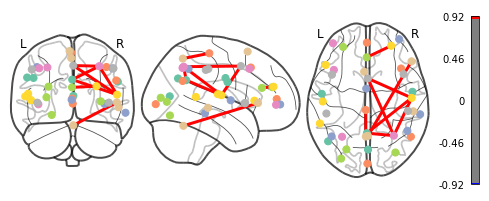

In [42]:
from nilearn import plotting
coords = dataset.region_coords

# We threshold to keep only the 20% of edges with the highest value
# because the graph is very dense
plotting.plot_connectome(correlation_matrix, coords,
                         edge_threshold="99%", colorbar=True)

plotting.show()

# Bien

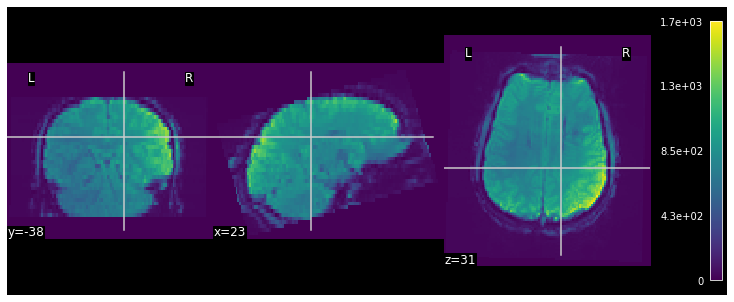

In [30]:
from nilearn import plotting
from matplotlib import pyplot as plt

fig=plt.figure(figsize=(10,4))
plotting.plot_img(mean_img, figure=fig, black_bg=True, colorbar=True, resampling_interpolation='continuous', bg_img=None, vmin=None, vmax=None)

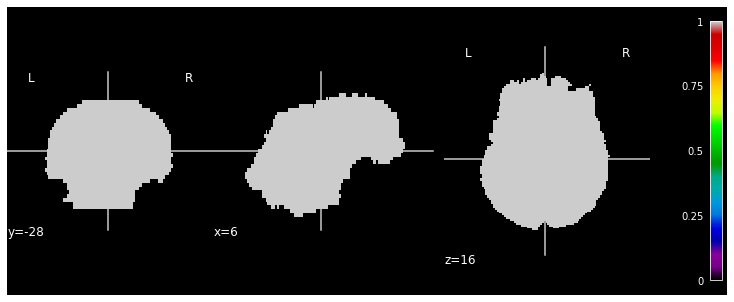

In [31]:
mask_3D = masking.compute_epi_mask(mean_img)

fig2=plt.figure(figsize=(10,4))
plotting.plot_epi(mask_3D, figure=fig2, black_bg=True, colorbar=True, resampling_interpolation='continuous', bg_img=None, vmin=None, vmax=None)

events_ = pd.read_table('/Users/juliagarciacornet/Desktop/Q4/Neuroimatge/project/task-eegfmriNF_events.tsv')



del events_['stim_file']

events=events_.replace({'Task-NF':'Task'})

events


In [32]:
import numpy as np
tr = 2  # repetition time of MRI scans is 7 seconds
n_scans = fmri_img.shape[3]  # the acquisition comprises 96 scans
frame_times = np.arange(n_scans) * tr  # here are the correspoding frame times
frame_times

array([  0,   2,   4,   6,   8,  10,  12,  14,  16,  18,  20,  22,  24,
        26,  28,  30,  32,  34,  36,  38,  40,  42,  44,  46,  48,  50,
        52,  54,  56,  58,  60,  62,  64,  66,  68,  70,  72,  74,  76,
        78,  80,  82,  84,  86,  88,  90,  92,  94,  96,  98, 100, 102,
       104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128,
       130, 132, 134, 136, 138, 140, 142, 144, 146, 148, 150, 152, 154,
       156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180,
       182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206,
       208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232,
       234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258,
       260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284,
       286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310,
       312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336,
       338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 36

In [33]:
from nilearn.glm.first_level import make_first_level_design_matrix
from nilearn.plotting import plot_design_matrix

hrf_model = 'spm'
X1 = make_first_level_design_matrix(frame_times, events, drift_model='Cosine',
                                    hrf_model=hrf_model)

plot_design_matrix(X1)

NameError: name 'events' is not defined

In [ ]:
from nilearn.glm.first_level import FirstLevelModel

fmri_glm = FirstLevelModel(signal_scaling=False, mask_img=mask, minimize_memory=False)
fmri_glm = fmri_glm.fit(fmri_img, design_matrices=X1)

In [ ]:
from nilearn import plotting

z_map = fmri_glm.compute_contrast('Task- Rest')

plotting.plot_stat_map(z_map, bg_img=mean_img)

In [ ]:
plotting.plot_stat_map(z_map, bg_img=mean_img, threshold=3.1)

In [ ]:
from nilearn.reporting import get_clusters_table
from nilearn import maskers
from nilearn import input_data

table = get_clusters_table(z_map, stat_threshold=3.1,
                           cluster_threshold=20).set_index('Cluster ID', drop=True)
print(table.head())

# get the 4 largest clusters' max x, y, and z coordinates
coords = table.loc[range(1,5), ['X', 'Y', 'Z']].values
print(coords)

# extract time series from each coordinate
masker = input_data.NiftiSpheresMasker(coords)
real_timeseries = masker.fit_transform(fmri_img)
# The predicted time series was also extracted with GLM, it is useful to assess the quality of the model fit.
predicted_timeseries = masker.fit_transform(fmri_glm.predicted[0])

print(real_timeseries.shape)
print(predicted_timeseries.shape)

In [ ]:
from matplotlib import pyplot as plt
# colors for each of the clusters
colors = ['blue', 'navy', 'purple', 'magenta']
# plot the time series and corresponding locations
fig1, axs1 = plt.subplots(2, 4)
for i in range(0, 4):
    # plotting time series
    axs1[0, i].set_title('Cluster peak {}\n'.format(coords[i]))
    axs1[0, i].plot(real_timeseries[:, i], c=colors[i], lw=2)
    axs1[0, i].plot(predicted_timeseries[:, i], c='r', ls='--', lw=2)
    axs1[0, i].set_xlabel('Time')
    axs1[0, i].set_ylabel('Signal intensity', labelpad=0)
    # plotting image below the time series
    roi_img = plotting.plot_stat_map(
        z_map, cut_coords=[coords[i][2]], threshold=3.1, figure=fig1,
        axes=axs1[1, i], display_mode='z', colorbar=False, bg_img=mean_img)
    roi_img.add_markers([coords[i]], colors[i], 300)
fig1.set_size_inches(24, 14)

In [ ]:
# get the 4 largest clusters' max x, y, and z coordinates
coords = table.loc[range(1, 15), ['X', 'Y', 'Z']].values

# extract time series from each coordinate
masker = input_data.NiftiSpheresMasker(coords)
real_timeseries = masker.fit_transform(fmri_img)

In [ ]:
from nilearn.connectome import ConnectivityMeasure
correlation_measure = ConnectivityMeasure(kind='correlation')
correlation_matrix = correlation_measure.fit_transform([real_timeseries])[0]
print(correlation_matrix.shape)
# Plot the correlation matrix
import numpy as np
from nilearn import plotting
# Make a large figure
# Mask the main diagonal for visualization:
np.fill_diagonal(correlation_matrix, 0)
# The labels we have start with the background (0), hence we skip the
# first label
# matrices are ordered for block-like representation
plotting.plot_matrix(correlation_matrix, figure=(10, 8), labels=np.arange(14), reorder=False, cmap='magma_r')

In [ ]:
# We will roughly adjust the coordinates to plot them into the glass brain
coords_plot = coords.copy()
coords_plot[:,1] = coords[:,1] - 30 


plotting.plot_connectome(correlation_matrix,
                         coords_plot, edge_threshold='95%',
                         display_mode="z")